In [2]:
# Import the required packages
#import holoviews as hv
import panel as pn
import os
import pandas as pd
import sys
pn.extension()
from IPython.display import clear_output


sys.path.append('../src/data')
sys.path.append('../src/features')
sys.path.append('../src/models')
sys.path.append('../src/visualization')
from utils import *
from model import BoltDetector
from visualization import *

In [3]:
# Create the dateframe including all the model results
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def spliting_files(x):
    return int(str(x).split('/')[-1].split('-')[0].split('=')[-1])


def generate_df (model_path):
    
    model_files = filelist(model_path, '.ckpt')
    model_parameters = {}

    model_parameters['filename'] = model_files
    
    return pd.DataFrame(model_parameters)
                                
model_path = '../models/detector/'

df = generate_df(model_path)
df['epoch'] = df.filename.apply(spliting_files)
df = df.sort_values(by=['epoch'])
df.head()


,filename,epoch
0,../models/detector/epoch=13-valid_loss=0.50.ckpt,13
1,../models/detector/epoch=14-valid_loss=0.48.ckpt,14


Column
    [0] Column
        [0] Select(options=[13, 14], value=13)
    [1] ParamFunction(function, _pane=Plotly, defer_load=False)
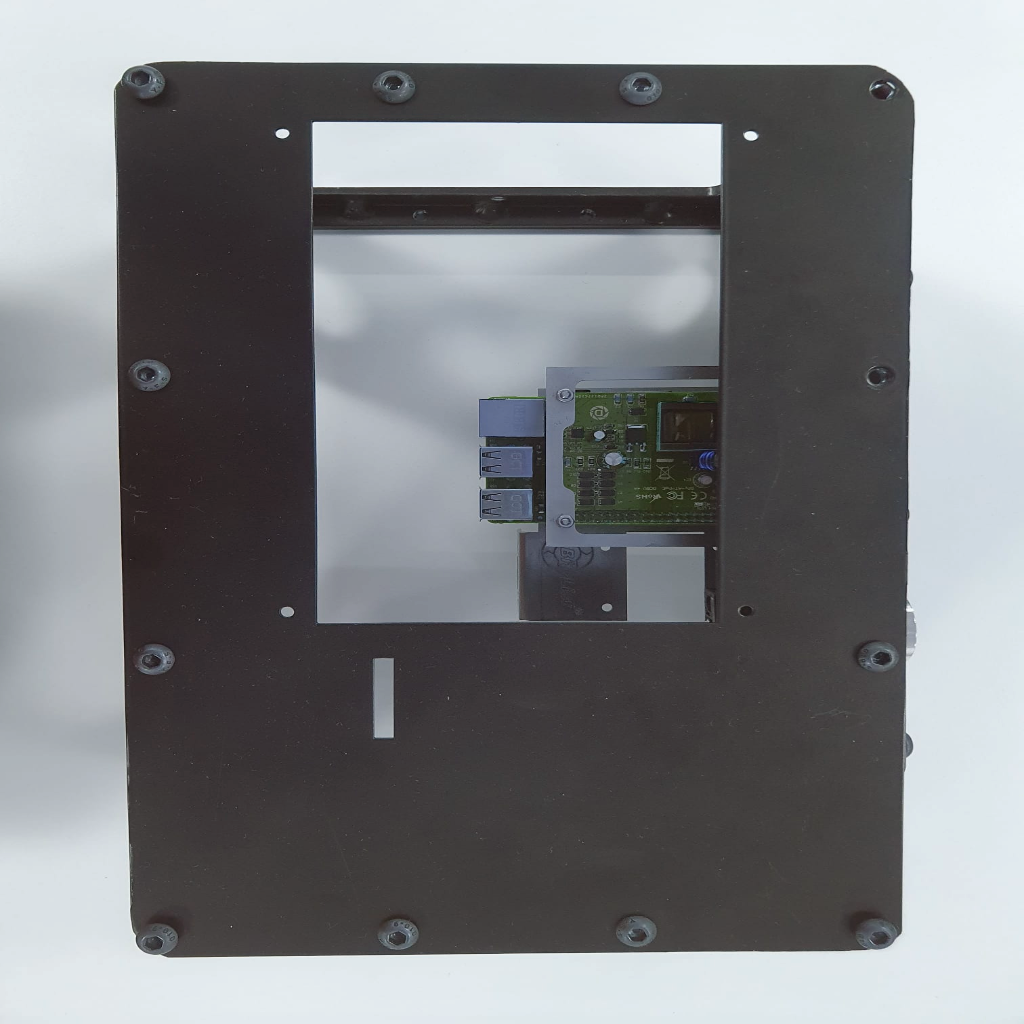

In [7]:
# Define the panel function indicating drop down menu to select number of epochs
import plotly.express as px
pn.extension('plotly')
#pn.extension()
import plotly.graph_objects as go


# Intialise epoch and index of the image
epoch = list(df.epoch.unique())
epoch
index = 9

# create widget
select = pn.widgets.Select(name = 'Select no of epoch', options = epoch)

# create function using depends decorator
@pn.depends(select)
def plot_predicted_bolts(epoch):
    # Load the model and the images
    images_df = pd.read_csv('~/work/digf-coref/data/interim/dataset_strat.csv');
    images_df["bboxes"] = images_df["bboxes"].apply(eval)

    model = BoltDetector(images_df, num_classes=1, img_size=1024);    
    path = (df[df['epoch'] == epoch].filename).to_string(index=False)
    model = model.load_from_checkpoint(path);
    model.eval();

    img = model.test_dataset[index][0]
    
    # Predict the number of bolts 
    with torch.no_grad():
            out = model.predict(img.unsqueeze(0))
    clear_output(wait=True)
    
    img = img.cpu().permute(1,2,0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 255)

    w=100
    h=100
    i= 0
    # Show image as plotly object
    rev_geog_fig = px.imshow(img)
    
    # Draw bounding boxes according to the model predictions
    for b, a in zip(out[0][0], out[2][0]):
        i += 1
        xc = (int(b[0])+int(b[2]))/2
        yc = (int(b[1])+int(b[3]))/2
        rev_geog_fig .add_trace(
            go.Scatter(
                x=[xc + xi for xi in [w//2, 0, -w//2, 0, w//2]],
                y=[yc + yi for yi in [0, -h//2, 0, h//2, 0]],
                mode = 'lines',
                name = 'Bolt {}'.format(i),
                hovertext = str("Predicted class confidence = "+"{:.2f}".format(a)),
                hoverinfo = 'text'
            )
        )
        
    # Show the number of predicted bolts
    rev_geog_fig.update_layout(title = 'Prediction: Counted Bolts = {}'.format(len(out[2][0])))
    rev_geog_fig_pane = pn.pane.Plotly(rev_geog_fig) 
    
    return(rev_geog_fig_pane) 


rev_geog_layout = pn.Column(pn.Column(select), plot_predicted_bolts)
rev_geog_layout.servable()


In [ ]:
epoch = 13
images_df = pd.read_csv('~/work/digf-coref/data/interim/dataset_strat.csv');
images_df["bboxes"] = images_df["bboxes"].apply(eval)

model = BoltDetector(images_df, num_classes=1, img_size=1024);    
path = (df[df['epoch'] == epoch].filename).to_string(index=False)
model = model.load_from_checkpoint(path);
model.eval();



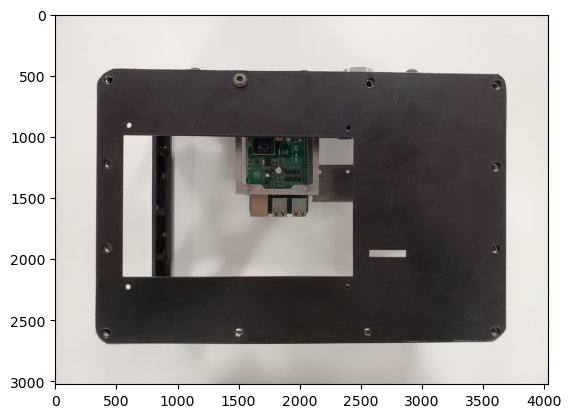

In [19]:
index = 5
#img = model.test_dataset[index][0]
df = pd.read_csv('~/work/digf-coref/data/interim/dataset_strat.csv')
img=cv2.imread(df.filename[index])
img = img.transpose(1,0,2)
img = np.flipud(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [21]:
transform = A.Compose(
        [
            A.Resize(height=1024, width=1024, p=1),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(p=1),
        ],
        p=1.0)

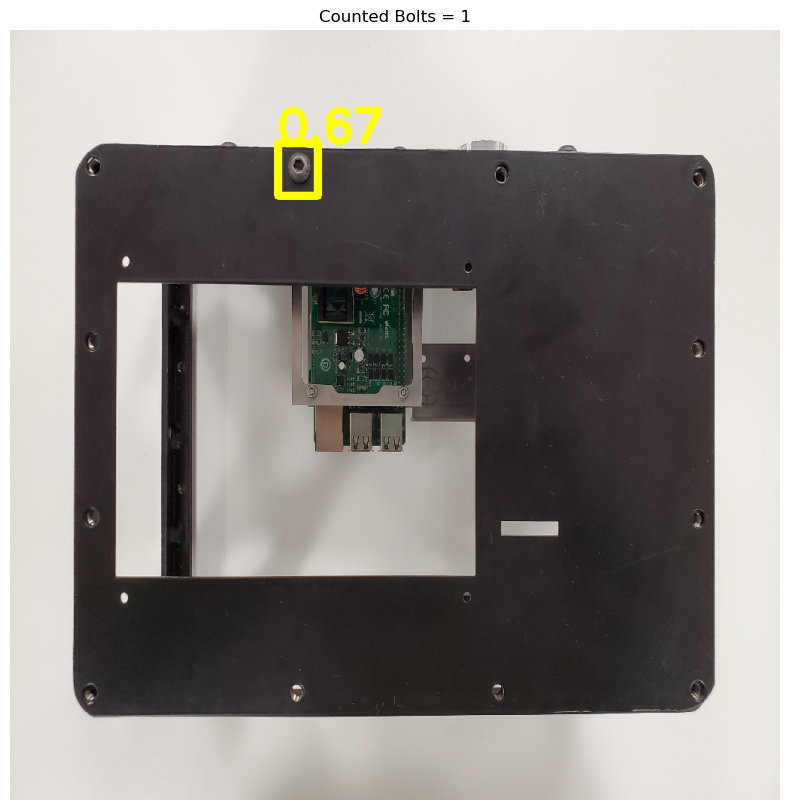

In [22]:
transformed = transform(image=img)['image']
with torch.no_grad():
    out = model.predict(transformed.unsqueeze(0))
show_prediction_without_gt(transformed, out)